<a href="https://colab.research.google.com/github/tvrlexe/Machine-Learning-00/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt

# Set device to CUDA if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
!pip install torchvision

In [3]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

train_data = FashionMNIST(root='./data',
                          train=True,
                          download=True,
                          transform=transforms.ToTensor())
test_data = FashionMNIST(root='./data',
                         train=False,
                         download=True,
                         transform=transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=32,
                                               shuffle = True)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size=32,
                                              shuffle = False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.77MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 28.2MB/s]


In [4]:
from torch import nn
class FashionMNISTV0(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
                        nn.Conv2d(in_channels= input_shape,
                                  out_channels = hidden_units,
                                  kernel_size = 3,
                                  stride = 1,
                                  padding = 1),
                        nn.Conv2d(in_channels= hidden_units,
                                  out_channels = hidden_units,
                                  kernel_size = 3,
                                  stride = 1,
                                  padding = 1),

                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size = 2,
                                     stride = 2),
                        nn.ReLU())
    self.conv_block_2 = nn.Sequential(
                        nn.Conv2d(in_channels= hidden_units,
                                  out_channels = hidden_units,
                                  kernel_size = 3,
                                  stride = 1,
                                  padding = 1),
                        nn.Conv2d(in_channels= hidden_units,
                                  out_channels = hidden_units,
                                  kernel_size = 3,
                                  stride = 1,
                                  padding = 1),

                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size = 2,
                                     stride = 2),
                        nn.ReLU())
    self.classifier = nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(in_features = hidden_units * 7 * 7,
                                  out_features = output_shape))

  def forward(self, x):
      return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [5]:
torch.manual_seed(42)
model_0 = FashionMNISTV0(input_shape = 1,
                         hidden_units = 10,
                         output_shape = len(train_data.classes)).to(device) # Move model to device

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [7]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
torch.manual_seed(42)

epochs = 5

start_time = timer()
all_train_loss = []
all_test_loss = []
all_train_acc = []
all_test_acc = []
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")

  train_acc, train_loss = 0,0

  for X, y in (train_dataloader):
    model_0.train()

    # Move data to device
    X, y = X.to(device), y.to(device)

    y_logit = model_0(X)

    y_pred = torch.softmax(y_logit, dim = 1).argmax(dim = 1)

    train_acc += (y_pred == y).sum().item() / len(y_pred)

    loss = loss_fn(y_logit, y)

    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_acc /= len(train_dataloader)
  train_loss /= len(train_dataloader)

  model_0.eval
  with torch.inference_mode():
    test_loss, test_acc = 0, 0
    for X, y in test_dataloader:

      # Move data to device
      X, y = X.to(device), y.to(device)

      test_logit = model_0(X)
      test_pred = torch.softmax(test_logit, dim = 1).argmax(dim = 1)
      test_acc += (test_pred == y).sum().item()/len(test_pred)
      test_loss += loss_fn(test_logit, y)
    test_acc /= len(test_dataloader)
    test_loss /= len(test_dataloader)
  all_train_loss.append(train_loss)
  all_test_loss.append(test_loss)
  all_train_acc.append(train_acc)
  all_test_acc.append(test_acc)


  print(f"Train accuracy: {train_acc: 3f}| Train Loss{train_loss: 3f}| Test Accuracy{test_acc: 3f}| Test Loss{test_loss: 3f}")

end_time = timer()
print(f"Total training time: {end_time - start_time}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-------
Train accuracy:  0.805550| Train Loss 0.543559| Test Accuracy 0.869409| Test Loss 0.373762
Epoch: 1
-------
Train accuracy:  0.875883| Train Loss 0.350860| Test Accuracy 0.875899| Test Loss 0.338613
Epoch: 2
-------
Train accuracy:  0.885283| Train Loss 0.319556| Test Accuracy 0.882488| Test Loss 0.327616
Epoch: 3
-------
Train accuracy:  0.892183| Train Loss 0.303574| Test Accuracy 0.881290| Test Loss 0.323974
Epoch: 4
-------
Train accuracy:  0.895383| Train Loss 0.292314| Test Accuracy 0.886981| Test Loss 0.314621
Total training time: 71.96259145900001


In [8]:
torch.manual_seed(42)
model_0.eval()
with torch.inference_mode():
  test_pred_labels = []
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    test_logit = model_0(X)
    test_pred = torch.softmax(test_logit, dim = 1).argmax(dim = 1)
    test_pred_labels.append(test_pred.cpu())
    print(f"Test Accuracy: {(test_pred == y).sum()/len(test_pred): 3f}")

Test Accuracy:  0.875000
Test Accuracy:  0.843750
Test Accuracy:  0.937500
Test Accuracy:  0.906250
Test Accuracy:  0.937500
Test Accuracy:  0.906250
Test Accuracy:  0.968750
Test Accuracy:  0.875000
Test Accuracy:  0.968750
Test Accuracy:  0.937500
Test Accuracy:  0.906250
Test Accuracy:  0.906250
Test Accuracy:  0.875000
Test Accuracy:  0.937500
Test Accuracy:  0.843750
Test Accuracy:  0.937500
Test Accuracy:  0.906250
Test Accuracy:  0.875000
Test Accuracy:  0.843750
Test Accuracy:  0.875000
Test Accuracy:  0.906250
Test Accuracy:  0.875000
Test Accuracy:  0.875000
Test Accuracy:  0.843750
Test Accuracy:  0.906250
Test Accuracy:  0.875000
Test Accuracy:  0.937500
Test Accuracy:  0.906250
Test Accuracy:  0.843750
Test Accuracy:  0.843750
Test Accuracy:  0.843750
Test Accuracy:  0.906250
Test Accuracy:  0.937500
Test Accuracy:  0.906250
Test Accuracy:  0.906250
Test Accuracy:  0.906250
Test Accuracy:  0.875000
Test Accuracy:  0.843750
Test Accuracy:  0.781250
Test Accuracy:  0.875000


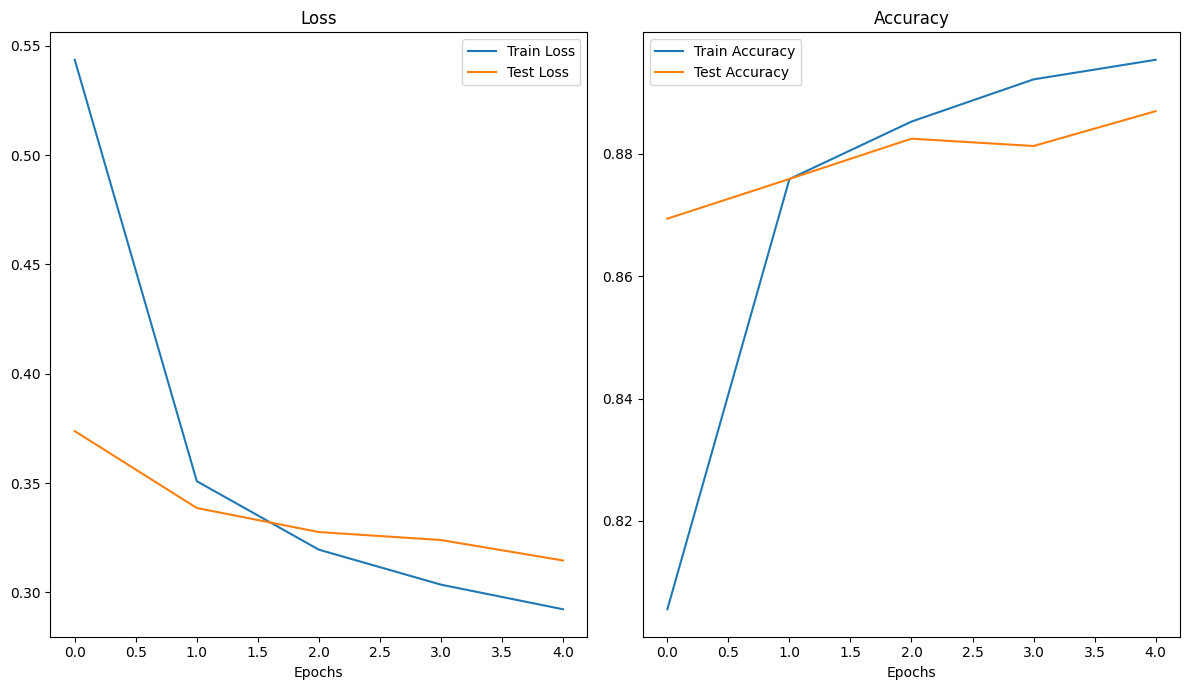

In [9]:
plt.figure(figsize = (12, 7))


epochs_list = range(epochs)


plt.subplot(1, 2, 1)
# Move tensors to CPU before converting to numpy
plt.plot(epochs_list, [loss.cpu().detach().numpy() for loss in all_train_loss], label='Train Loss')
plt.plot(epochs_list, [loss.cpu().detach().numpy() for loss in all_test_loss], label='Test Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, all_train_acc, label='Train Accuracy')
plt.plot(epochs_list, all_test_acc, label='Test Accuracy')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
!pip install torchmetrics -U mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.2 MB/s eta 0:00:00


In [11]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

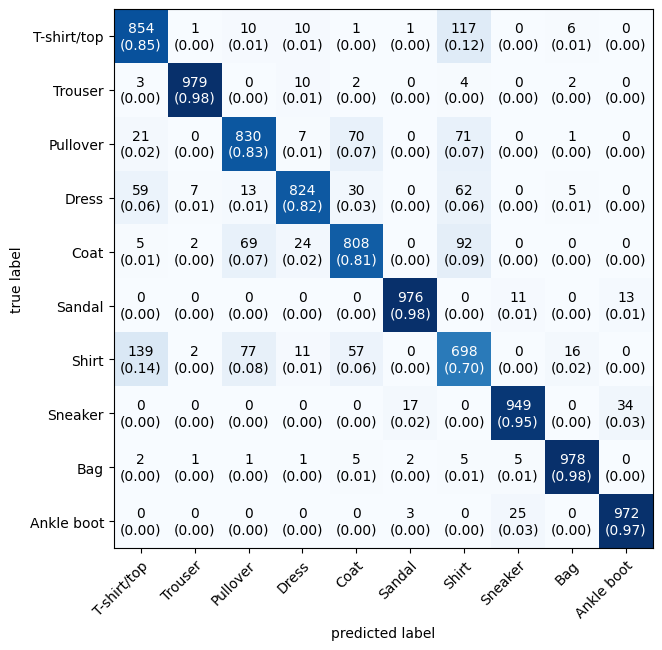

In [12]:
test_pred = torch.cat(test_pred_labels)
confmat = ConfusionMatrix(task = "Multiclass", num_classes = len(train_data.classes))


confmat_tensor = confmat(preds = test_pred,
                         target = test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    figsize = (10,7),
    class_names = test_data.classes,
    show_normed = True
)

In [13]:
test_preds = model_0(test_data[0][0].unsqueeze(0).to(device)).argmax(dim = 1)

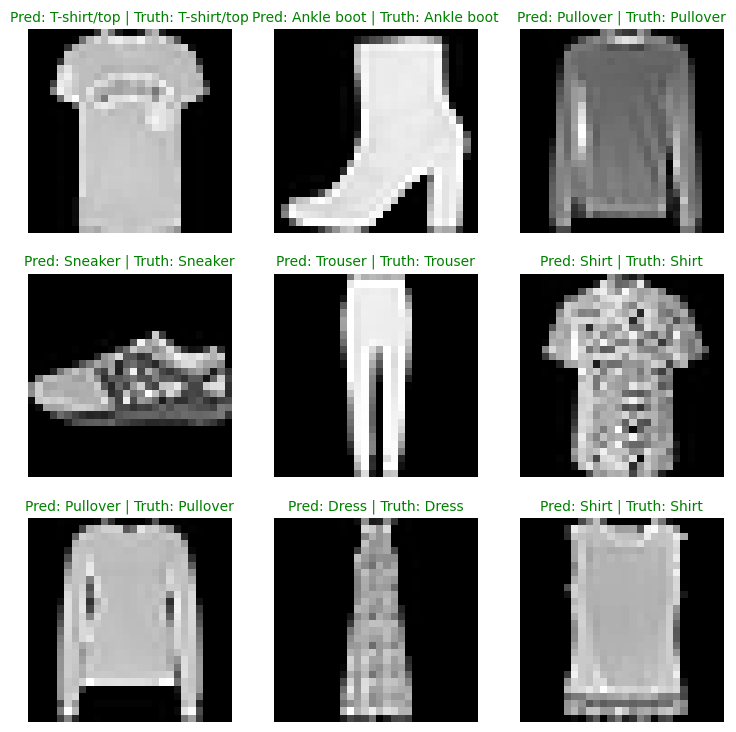

In [15]:
import random
import numpy as np
test_samples = []
test_labels = []
for sample , label in random.sample(list(test_data), k = 9):
  test_samples.append(sample)
  test_labels.append(label)

class_names = test_data.classes

sample = torch.from_numpy(np.array(test_samples)).to(device)

test_preds = torch.softmax(model_0(sample), dim = 1).argmax(dim = 1)

plt.figure(figsize = ( 9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze().cpu(), cmap = "gray")

  pred_label = class_names[test_preds[i]]
  truth_label = class_names[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  plt.title(title_text)

  if pred_label == truth_label:
    plt.title(title_text, fontsize = 10, c="g")
  else:
    plt.title(title_text, fontsize = 10, c = "r")
  plt.axis(False)